In [1]:
import sys
import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

%load_ext autoreload
%autoreload 2
%matplotlib widget

# Load Data from Folders


In [2]:
from io import StringIO


data: dict[str, dict[str, dict[str, pd.DataFrame]]] = {}

directories = []
for root, dirs, files in os.walk("../../../../data/benchmark-cluster/explodingLiquidPause/"):
    for name in dirs:
        directories.append(os.path.join(root, name))


for directory in directories:
    files = os.listdir(directory)

    for file in files:
        # skip folders
        if ".csv" not in file:
            continue

        file_type = file.split("_")[1]

        print(f"Processing {file}")

        tuning_algorithm = directory.split("/")[-1]
        thread = directory.split("/")[-2]
        scenario = directory.split("/")[-3]

        with open(os.path.join(directory, file)) as f:
            print(directory, file)
            content = f.read()
            df_tuners = pd.read_csv(StringIO(content))

        if not scenario in data:
            data[scenario] = {}

        if not thread in data[scenario]:
            data[scenario][thread] = {}

        if not tuning_algorithm in data[scenario][thread]:
            data[scenario][thread][tuning_algorithm] = {}

        data[scenario][thread][tuning_algorithm][file_type] = df_tuners

Processing AutoPas_tuningData_Rank0_2024-06-10_12-51-21.csv
../../../../data/benchmark-cluster/explodingLiquidPause/12/BayesianClusterSearch AutoPas_tuningData_Rank0_2024-06-10_12-51-21.csv
Processing AutoPas_iterationPerformance_Rank0_2024-06-10_12-51-21.csv
../../../../data/benchmark-cluster/explodingLiquidPause/12/BayesianClusterSearch AutoPas_iterationPerformance_Rank0_2024-06-10_12-51-21.csv
Processing AutoPas_tuningResults_Rank0_2024-06-10_12-51-21.csv
../../../../data/benchmark-cluster/explodingLiquidPause/12/BayesianClusterSearch AutoPas_tuningResults_Rank0_2024-06-10_12-51-21.csv
Processing AutoPas_tuningResults_Rank0_2024-06-10_12-50-30.csv
../../../../data/benchmark-cluster/explodingLiquidPause/12/FuzzyTuning [Individual] AutoPas_tuningResults_Rank0_2024-06-10_12-50-30.csv
Processing AutoPas_iterationPerformance_Rank0_2024-06-10_12-50-30.csv
../../../../data/benchmark-cluster/explodingLiquidPause/12/FuzzyTuning [Individual] AutoPas_iterationPerformance_Rank0_2024-06-10_12-50

# Make Line Plot of Smoothed Value over Iterations


5.445196122021268
3.7015733732230345
3.6489577219946754
3.361807346906855
3.0728024924720736


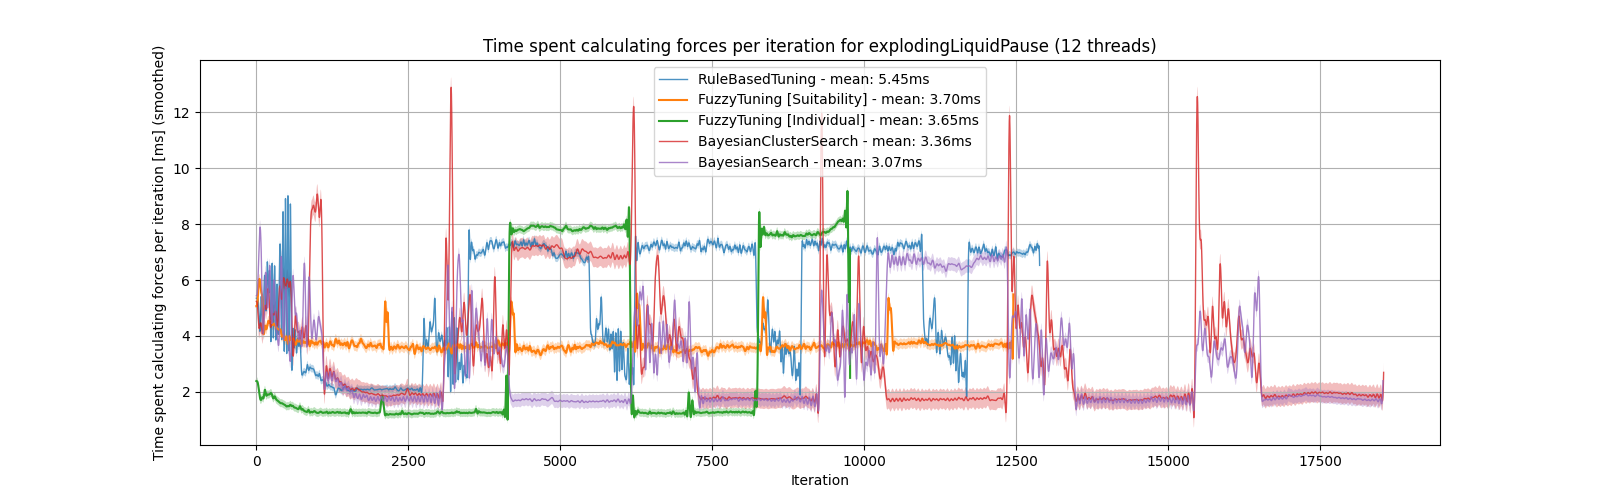

6.247535909120328
5.990284050698905
5.430526827031984
4.422524773065085
4.306778383663963


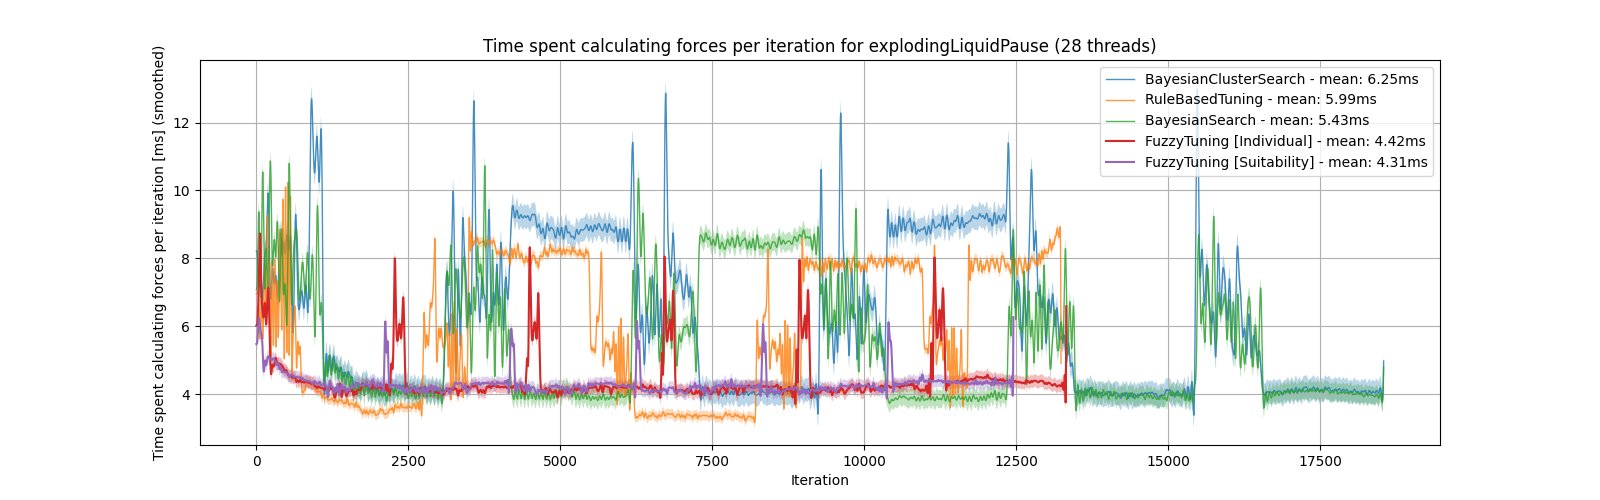

5.449138516477652
5.449138516477652
5.2815269303570345
3.7998643860291255
3.7015733732230345


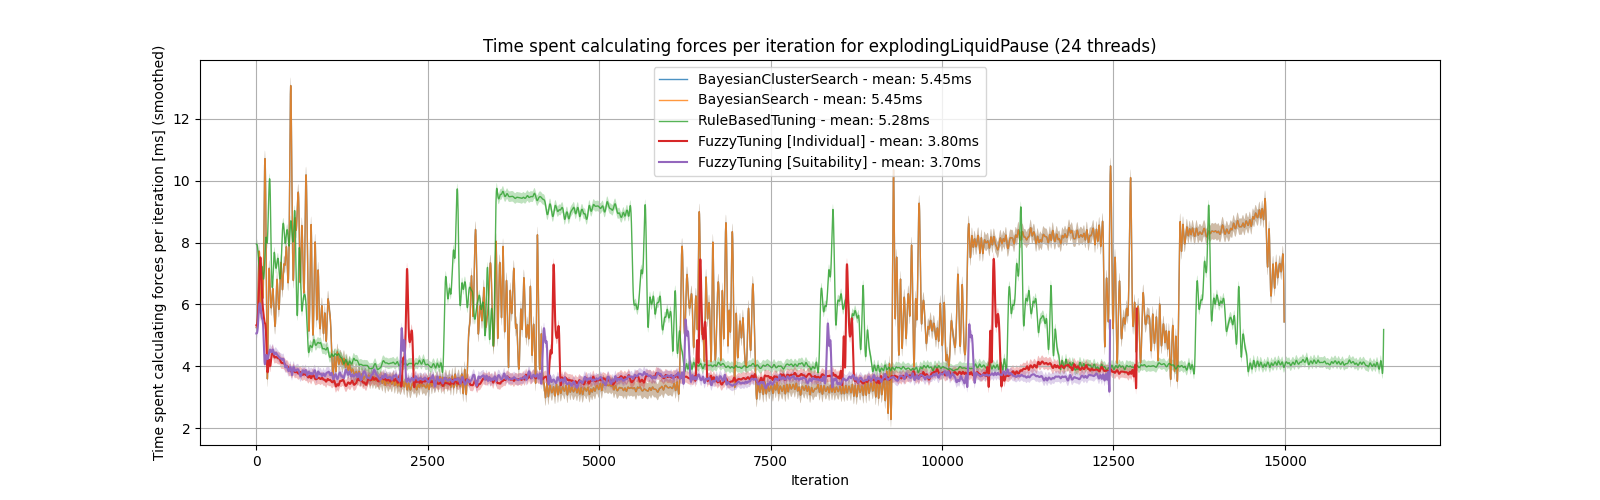

4.40664300610746
2.875864666522842
2.0944216689926933
1.9340002655196589
1.5439098704375152


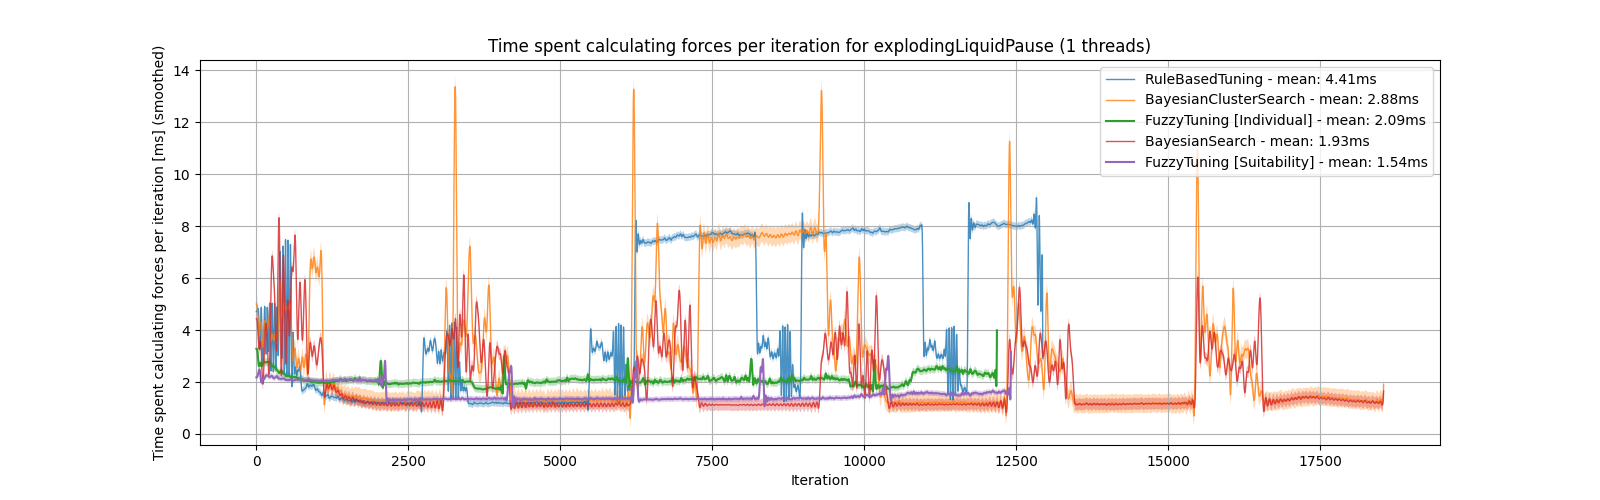

In [3]:
from scipy.signal import lfilter
from tsmoothie.smoother import *

for scenario, s_data in data.items():

    for threads, r_data in s_data.items():
        fig, ax = plt.subplots(1, 1, figsize=(16, 5))

        # sort by mean time spent calculating forces
        for tuning_algorithm, logs in sorted(r_data.items(), key=lambda x: x[1]["iterationPerformance"]["iteratePairwiseTotal[ns]"].mean(), reverse=True):

            iteration_data = logs["iterationPerformance"]

            time_s = iteration_data["iteratePairwiseTotal[ns]"] / 1e9

            first_k = 1000000

            x = iteration_data["Iteration"][:first_k]
            y = time_s[:first_k] * 1000

            mean = y.mean()

            print(mean)

            # ax.plot(x, y, label=f"{tuning_algorithm} - mean: {meanNS:.2f}ns")

            if np.logical_or(np.isnan(y), np.isinf(y)).any():
                raise ValueError(f"Found NaN or Inf in {
                                 tuning_algorithm + threads + scenario}")

            n = int(len(y)/20)

            smoother = SplineSmoother(n_knots=n, spline_type="cubic_spline")
            smoother.smooth(y)

            low, up = smoother.get_intervals('sigma_interval', n_sigma=0.1)

            linewidth = 1.5 if "Fuzzy" in tuning_algorithm else 1
            opacity = 1 if "Fuzzy" in tuning_algorithm else 0.8

            ax.plot(smoother.smooth_data[0], label=f"{
                    tuning_algorithm} - mean: {mean:.2f}ms", linewidth=linewidth, alpha=opacity)

            plt.fill_between(
                range(len(smoother.data[0])), low[0], up[0], alpha=0.3)

        ax.legend()
        ax.set_xlabel("Iteration")
        ax.set_ylabel(
            "Time spent calculating forces per iteration [ms] (smoothed)")

        # set y axis to mikro seconds

        ax.set_title(f"Time spent calculating forces per iteration for {
                     scenario} ({threads} threads)")
        # ax.set_xlim(0, df["Iteration"].max())
        # log
        ax.grid()
        plt.show()

# Make bar plots about total time

18541
FuzzyTuning [Suitability] - 28.62563290778197
BayesianSearch - 35.858298923
FuzzyTuning [Individual] - 38.83267216479353
BayesianClusterSearch - 53.321406782
RuleBasedTuning - 81.70356797623842


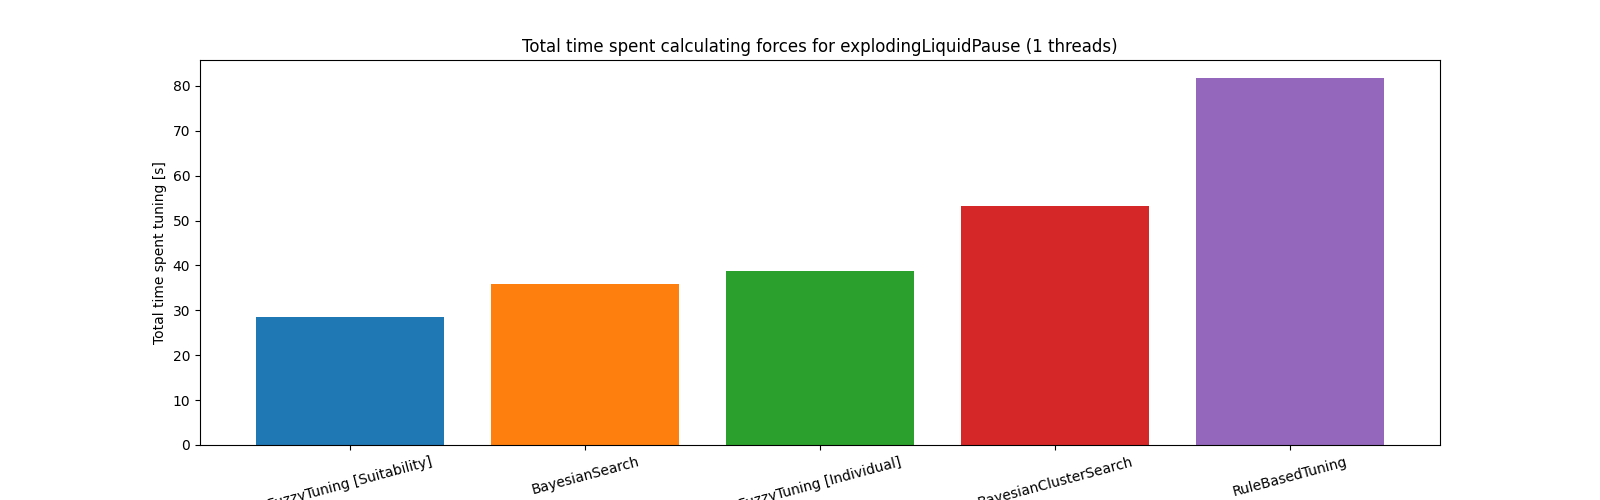

BayesianSearch - 56.97283101292472
BayesianClusterSearch - 62.331270019
FuzzyTuning [Individual] - 67.65532512350327
FuzzyTuning [Suitability] - 68.63087191292828
RuleBasedTuning - 100.95938129839635


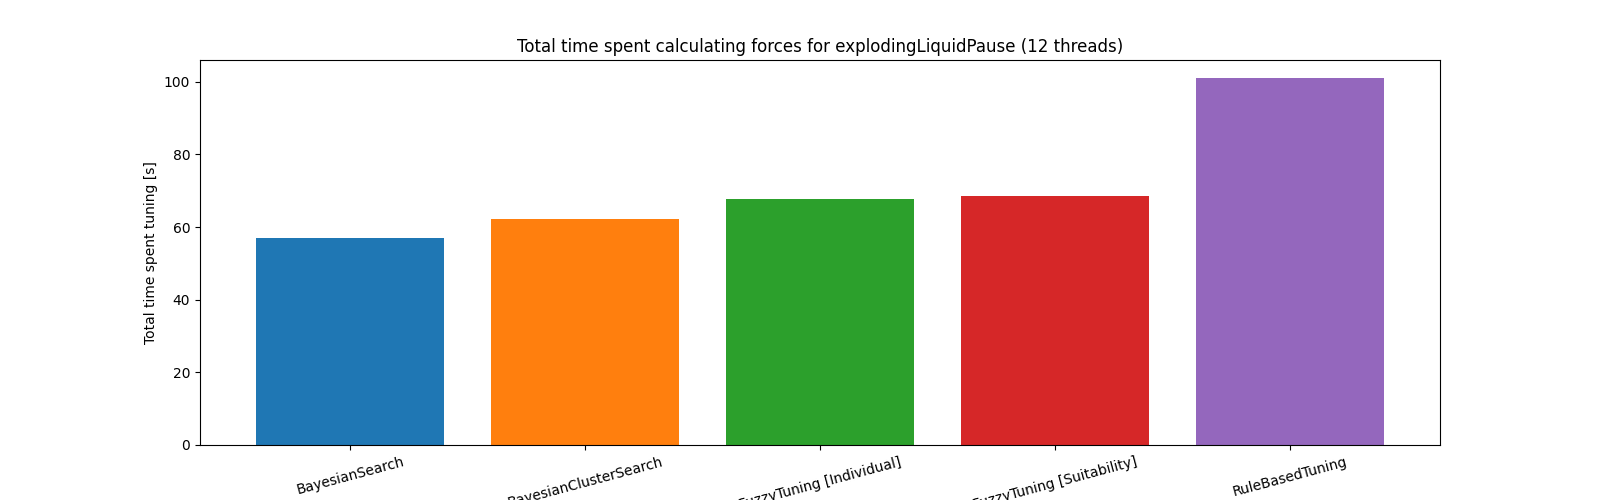

FuzzyTuning [Suitability] - 68.63087191292828
FuzzyTuning [Individual] - 70.45328558136602
RuleBasedTuning - 97.92479081574977
BayesianClusterSearch - 101.03247723401213
BayesianSearch - 101.03247723401213


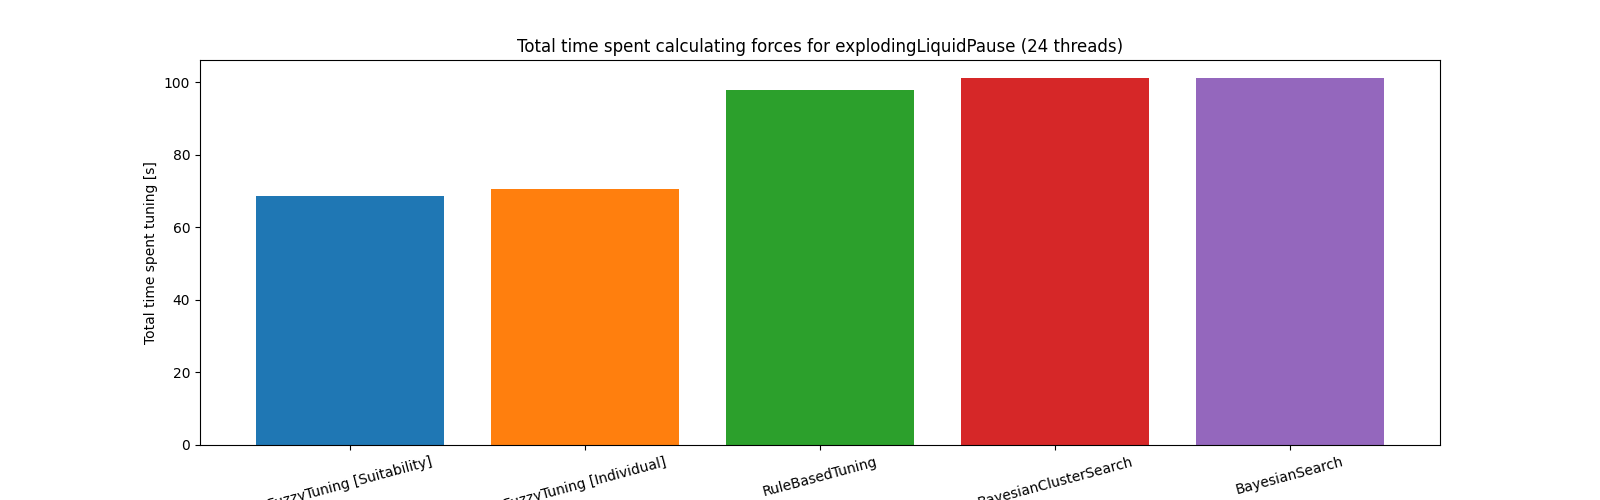

FuzzyTuning [Suitability] - 79.85197801151354
FuzzyTuning [Individual] - 81.99803181739975
BayesianSearch - 100.6873979
RuleBasedTuning - 111.06585658400839
BayesianClusterSearch - 115.835563291


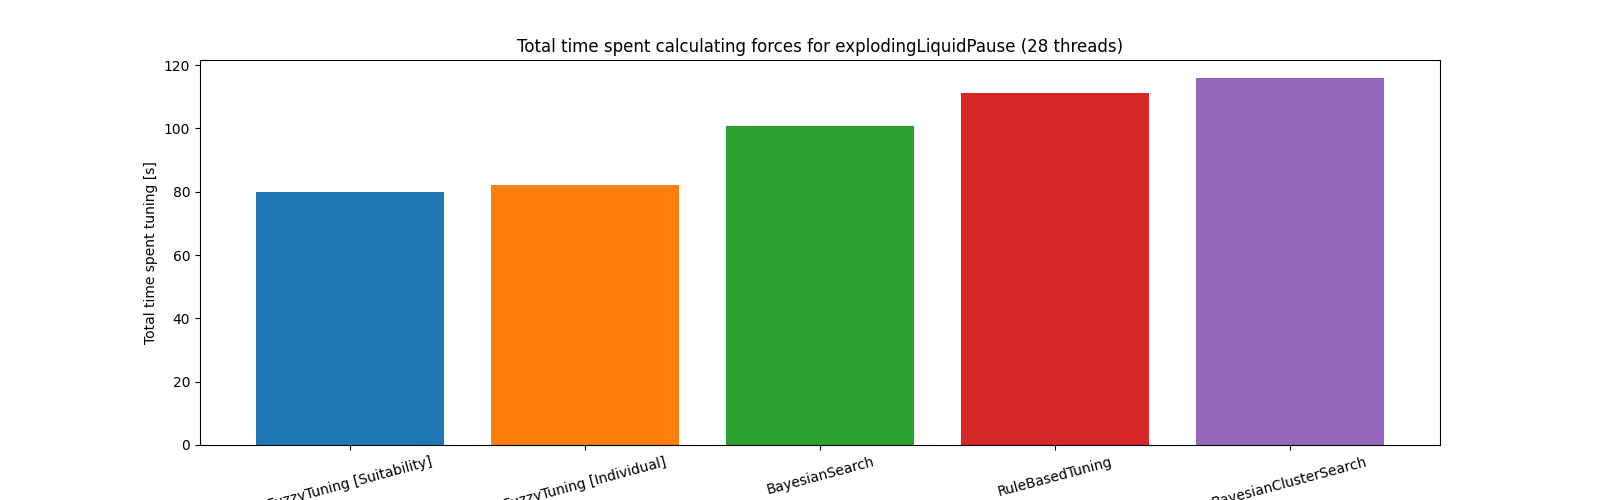

In [4]:
longest_simulation = 0
for scenario, s_data in data.items():

    for threads, r_data in s_data.items():

        # sort by mean time spent calculating forces
        for tuning_algorithm, logs in sorted(r_data.items(), key=lambda x: x[1]["iterationPerformance"]["iteratePairwiseTotal[ns]"].sum(), reverse=False):

            longest_simulation = max(
                longest_simulation, len(logs["iterationPerformance"]))

print(longest_simulation)


for scenario, s_data in data.items():

    for threads, r_data in sorted(s_data.items(), key=lambda x: x[0]):
        fig, ax = plt.subplots(1, 1, figsize=(16, 5))

        # sort by mean time spent calculating forces
        for tuning_algorithm, logs in sorted(r_data.items(), key=lambda x: x[1]["iterationPerformance"]["iteratePairwiseTotal[ns]"].sum() / (len(x[1]["iterationPerformance"]) / longest_simulation), reverse=False):

            iteration_data = logs["iterationPerformance"]

            completness = len(iteration_data) / longest_simulation

            total_time_s = iteration_data["iteratePairwiseTotal[ns]"].sum(
            ) / 1e9

            total_time_s = total_time_s / completness

            print(f"{tuning_algorithm} - {total_time_s}")

            ax.bar(tuning_algorithm, total_time_s, label=f"{tuning_algorithm}")

        # tilt x labels
        plt.xticks(rotation=15)

        ax.set_ylabel("Total time spent tuning [s]")

        ax.set_title(f"Total time spent calculating forces for {scenario} ({threads} threads)")

        plt.show()